# Boosting Methods

#### Imports

In [25]:
# Basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Custom imports
import utils
import model_utils

#Stylesheet
plt.style.use('./styles.txt')
warnings.filterwarnings('ignore')

#### Index

1. [Introduction](#intro)
2. [Data Loading and Preprocessing](#dl)
3. [AdaBoost](#adaboost)
4. [Gradient Boosting](#gboost)
5. [XGBoost](#xgboost)
6. [Using SMOTE](#smote)
7. [Evaluation of Ensemble Methods](#conc)

---

<a id='intro'></a>
## Introduction

In the previous notebook, we alluded to the idea of ensemble methods, briefly mentioning that ensemble methods are machine learning techniques that combine several base models in order to produce more accurate predictions than any of the individual models could.

There are a variety of ensemble methods, but they all share a common goal: to improve the accuracy of predictions by combining the predictions of multiple models. Consequently, ensemble methods are powerful tools. But they are not without their drawbacks. The most significant drawback is that they can be computationally expensive, since they require training multiple models. Additionally, ensemble methods can be difficult to interpret, since it can be difficult to understand how the individual models are combined.

A commonly used ensemble method is a Random Forest that creates an ensemble of decision trees from a randomly selected subset of the training data. It then aggregates the predictions of each tree to get the final classification. As the trees are trained in parallel, Random Forests require that individual trees have an accuracy greater than 50% in order for the random forest to be able to generate better results. Given the results of models so far, such a model would not generate any better results than we have already created.

In contrast to random forests, boosting methods learn from the mistakes made by previous models, meaning that we could potentially see results that improve on the models we have created so far. In this notebook we will therefore be looking at the following boosting methods: AdaBoost, Gradient Boosting, and XGBoost.

---
<a id='dl'></a>
### Data Loading and Processing

While ensemble methods can be made from different models, such as logistic regressions, we will primarily be using decision trees in our ensemble methods, meaning that the only preprocessing that we have to do is categorical. We do not need to preprocess our numerical data.

In [139]:
df = utils.LoadDf()
df.head()

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,avg_tempmax,avg_temp,avg_humidity,...,precip_variance,precip_delta,dew_variance,dew_delta,windspeed_variance,windspeed_delta,winddir_variance,winddir_delta,pressure_variance,pressure_delta
0,1992,1,0.10,A,43.325000,-101.018500,SD,5.257143,-2.928571,81.142857,...,0.000000,0.00,5.399184,3.5,47.062041,-1.8,1889.074286,-48.6,28.913469,-4.3
1,1992,1,1.00,B,33.058333,-79.979167,SC,13.700000,9.885714,81.428571,...,55.589796,-4.40,7.196327,0.1,5.575510,2.0,15648.559592,-14.9,19.071020,2.4
2,1992,2,0.25,A,40.775000,-74.854160,NJ,6.385714,1.585714,67.185714,...,9.546510,0.00,19.731020,4.0,34.516735,-10.6,16492.948163,-254.6,75.711429,-0.9
3,1992,3,1.91,B,31.018500,-83.297300,GA,14.457143,11.828571,78.957143,...,59.321224,-9.70,9.142041,-4.1,11.228571,0.2,16679.204898,223.6,21.585306,-8.4
4,1992,3,2.00,B,30.728900,-87.238100,FL,14.428571,10.985714,79.971429,...,0.213355,-1.32,10.262857,-7.9,27.382857,6.7,19587.093469,-24.8,13.107755,-2.7


In [140]:
df = utils.BasicCategoricalPreprocessing(df)
df.head()

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,avg_tempmax,avg_temp,avg_humidity,avg_precip,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,1992,1,0.10,A,43.325000,-101.018500,5.257143,-2.928571,81.142857,0.000000,...,1,0,0,0,0,0,0,0,0,0
1,1992,1,1.00,B,33.058333,-79.979167,13.700000,9.885714,81.428571,4.185714,...,0,0,0,0,0,0,0,0,0,0
2,1992,2,0.25,A,40.775000,-74.854160,6.385714,1.585714,67.185714,1.394286,...,0,0,0,0,0,0,0,0,0,0
3,1992,3,1.91,B,31.018500,-83.297300,14.457143,11.828571,78.957143,4.685714,...,0,0,0,0,0,0,0,0,0,0
4,1992,3,2.00,B,30.728900,-87.238100,14.428571,10.985714,79.971429,0.188571,...,0,0,0,0,0,0,0,0,0,0


---
<a id='adaboost'></a>
## AdaBoost

The first ensemble method that we will be looking at is adaptive boost (AdaBoost). This is a machine learning algorithm that is used to improve the performance of other machine learning algorithms. AdaBoost works by weighting data points so that the model pays more attention to data points that were previously misclassified. This process is repeated over multiple iterations, with the model becoming more and more accurate with each iteration. The algorithm is particularly effective because it can reduce the bias of the strong learner and improve the accuracy of the predictions.

When talking about boosting methods we often mention weak learners. What is meant by this? Typically, a weak learner is a decision stump, which is a decision tree with only one split. 

As previously mentioned, we can use a variety of models when using AdaBoost. To begin, we will be using decision trees, as decision trees have generally performed better in the classification models that we have created so far.

In [141]:
from sklearn.model_selection import train_test_split

X, y = model_utils.GenerateXy(df)

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [142]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)

score = adaboost.score(X_test, y_test)
print(f'The accuracy of the model is {score*100:.2f}%')

The accuracy of the model is 42.19%


From this model, we see that using the default parameters of AdaBoost has not been able to improve the accuracy of our model. Perhaps we can tweak the hyperparameters so that this score is improved.

One of the parameters that we can change within AdaBoost is the number of estimators. This parameter refers to the number of weak learners that we are iteratively training. We will see how increasing this number improves the ability of our model to classify the fire sizes, although it can already be somewhat expected that as the number of classifiers increases, the accuracy of the model increases. It should also be noted that if a model achieves a perfect fit, the procedure will be prematurely stopped.

In [106]:
cv_scores = []
n_est_range = list(range(1, 150, 10))

for n_est in n_est_range:
    print(f'Fitting model: {n_est}', end="\r")
    ada = AdaBoostClassifier(n_estimators=n_est)
    cv_scores.append(np.mean(cross_val_score(ada, X_train, y_train, cv=5)))

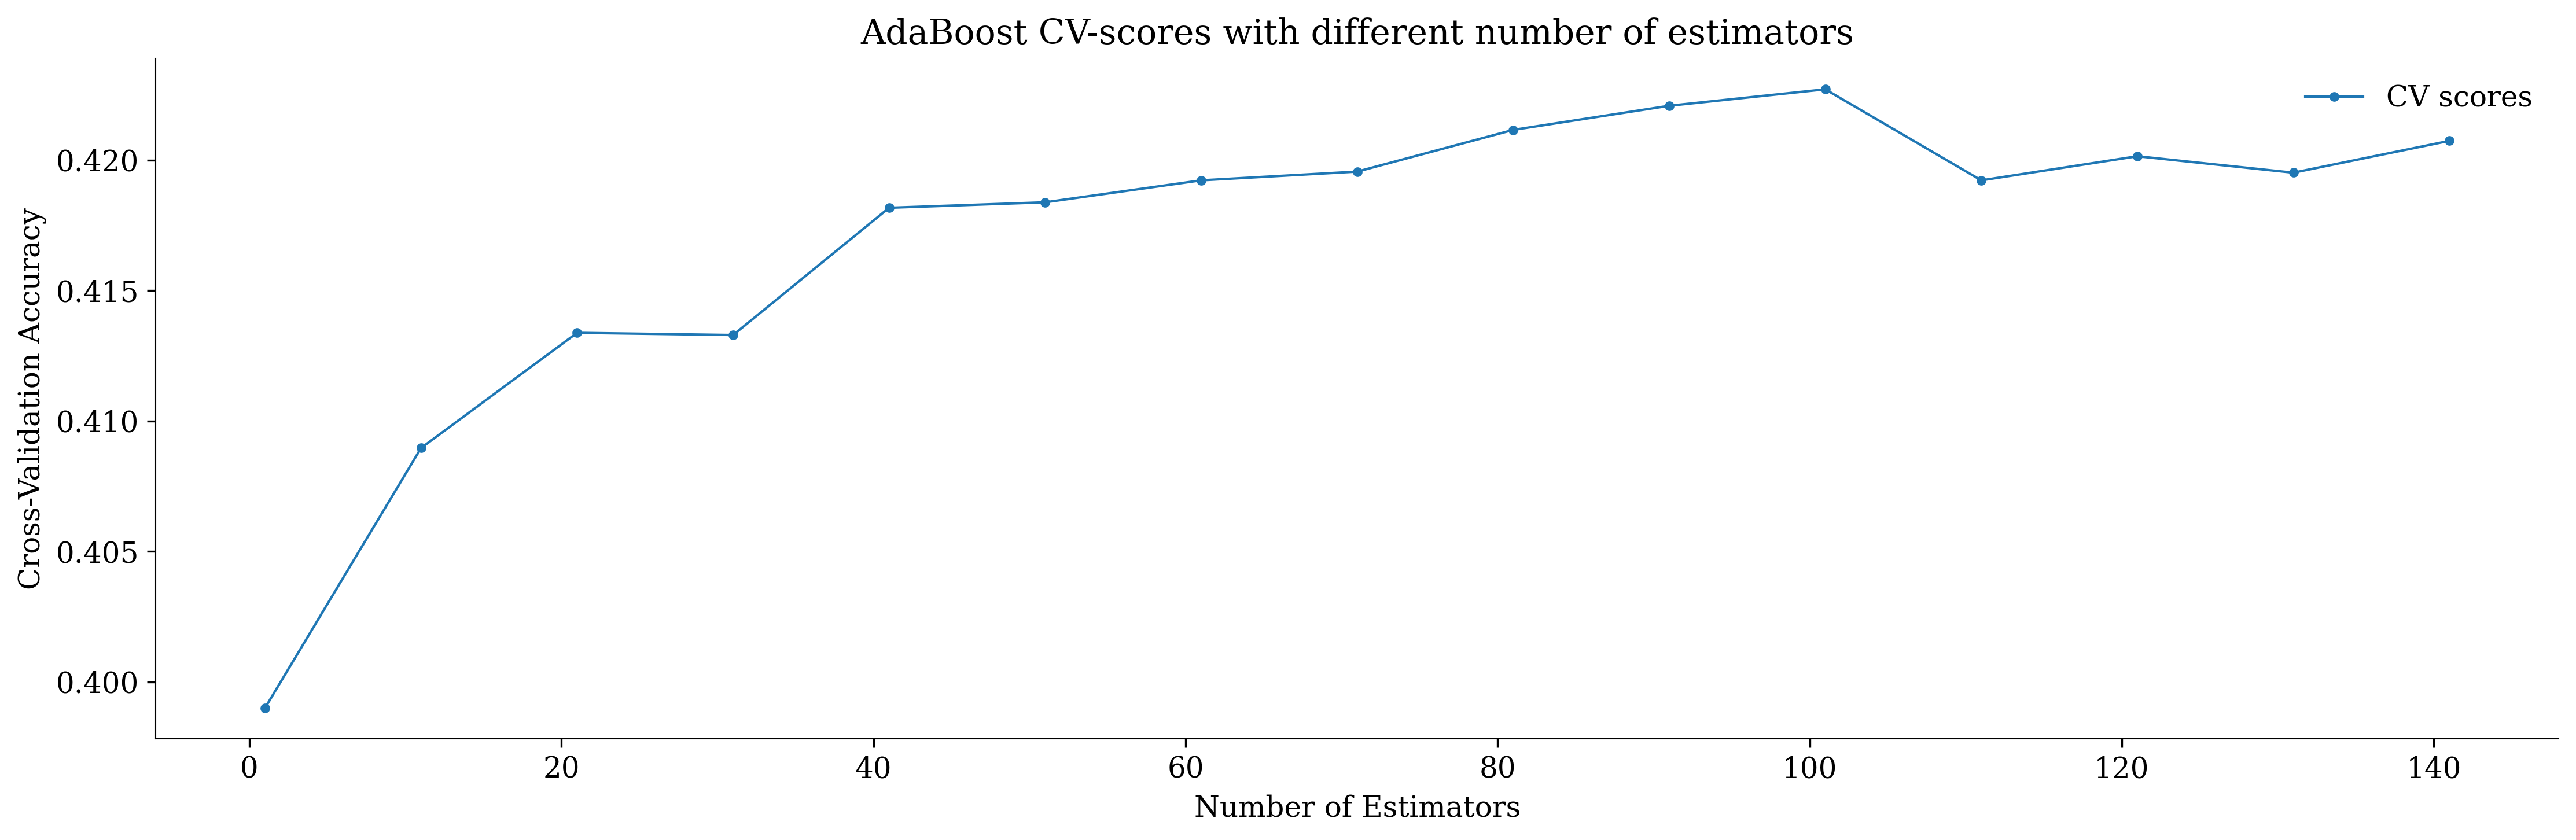

In [109]:
plt.figure(figsize=(15, 5))
plt.title("AdaBoost CV-scores with different number of estimators")
plt.plot(n_est_range, cv_scores, label="CV scores", marker='.')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validation Accuracy')
plt.legend()
plt.show()

Looking at the plot above, we notice that as the learning rate increases, the cross-validation accuracy increases, although it plateaus after reaching a peak at 101 estimators. We can build a model with this number of estimators and see how this performs on the test set.

In [144]:
adaboost = AdaBoostClassifier(n_estimators=101)
adaboost.fit(X_train, y_train)

score = adaboost.score(X_test, y_test)
print(f'The accuracy of the model is {score*100:.2f}%')

The accuracy of the model is 42.14%


Unfortunately, we see that this did not improve the test score of our model.

Additionally, we can alter the learning rate in AdaBoost, which is the weight that is assigned to each new classifier that is added to the ensemble. The higher the learning rate, the higher the contribution from an individual classifier. Given the way in which AdaBoost works, there is trade-off between learning rate and number of estimators that should be used. Since a lower learning rate means that a consequent model is going to be learning less from a predecessor, a higher number of iterations (number of estimators) should be used to ensure that the model continues to learn. Alternatively, using too high a learning rate will mean that a model is going to be more prone to overfitting as the importance of prior models is overestimated. 

We will therefore be trying a number of learning rates and number of estimators to determine which combination provides the best validation accuracy.

In [24]:
n_est_range = list(range(1, 150, 10))
learning_rate_range = [0.1, 0.5, 1.0, 1.5]

results = pd.DataFrame()

for learning_rate in learning_rate_range:
    for n_est in n_est_range:
        ada = AdaBoostClassifier(n_estimators=n_est, learning_rate=learning_rate)
        cv_score = np.mean(cross_val_score(ada, X_train, y_train, cv=5))
        
        row = pd.DataFrame(
            {
                "learning_rate": [learning_rate], 
                "n_estimators": [n_est],
                "cv_score": [cv_score]
            })
        
        results = pd.concat([results, row], axis=0, ignore_index=True)
    
        print(f'Learning rate: {learning_rate}, Estimators: {n_est}', end="   \r")

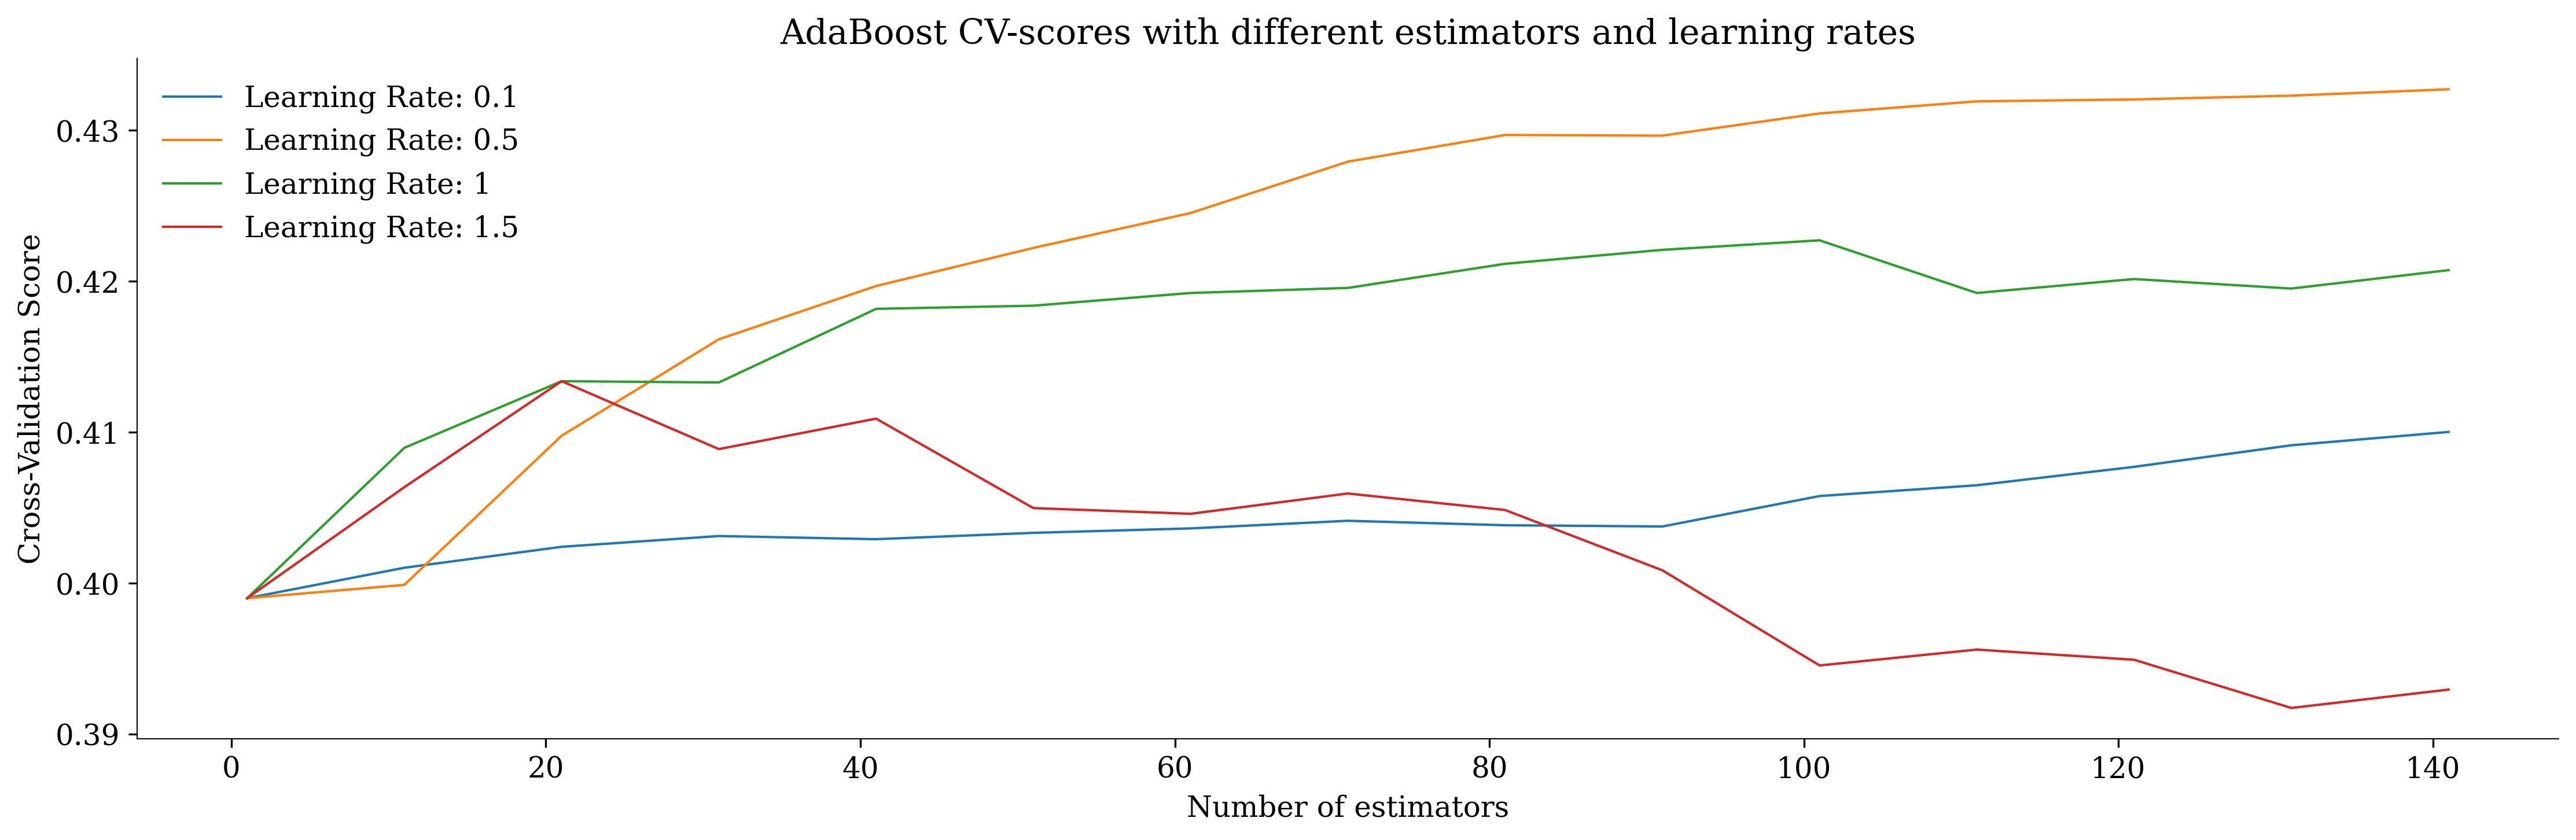

In [29]:
plt.figure(figsize=(15, 5))
plt.title('AdaBoost CV-scores with different estimators and learning rates')
for learning_rate in learning_rate_range:
    data = results[results['learning_rate'] == learning_rate]
    sns.lineplot(x='n_estimators', y='cv_score', data=data, label=f'Learning Rate: {learning_rate}')
plt.xlabel('Number of estimators')
plt.ylabel('Cross-Validation Score')
plt.legend()
plt.show()

Broadly speaking, we see that as the number of estimators increases, the cross-validation accuracy increases. This is unsuprising considering that we are combining the results of more weak learners. We also see that a learning rate of 0.5 and 141 estimators was able to achieve the highest cross-validation accuracy. Unfortunately, although we are improving the accuracy of the model, we are still not significantly increasing the performance of the model. We remain around 43%, which we were close to achieving in previous models already.

It is also interesting to note that at a learning rate of 1.5, as the number of estimators increased, we see the purpose of the trade-off discussed earlier. A higher amount of esimators meant that, at that specific learning rate, the model began to overfit and consequently began to score a lower accuracy.

Instead of a decision tree, we could use a logistic regreesion as the base estimator. We may run a similar process to the one we did above, to see if there is going to be any significant difference in model accuracy. As we are going to be using logistic regression, we will have to do some preprocessing on the numeric columns in our data set.

In [46]:
df, _ = utils.BasicNumericPreprocessing(df)

X, y = model_utils.GenerateXy(df)

X_rem, X_test, y_rem, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

col_transformer = model_utils.CreateColumnTransformer(X)

In [51]:
from tempfile import mkdtemp
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

cachedir = mkdtemp()

estimators = [('normalise', col_transformer),
              ('model', AdaBoostClassifier(base_estimator=LogisticRegression()))]

pipe = Pipeline(estimators, memory=cachedir)

params = [{'model__n_estimators': n_est_range,
           'model__learning_rate': learning_rate_range}]

grid = GridSearchCV(pipe, param_grid=params, cv=5, verbose=2)
fittedgrid = grid.fit(X_rem, y_rem)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END ....model__learning_rate=0.1, model__n_estimators=1; total time=   1.0s
[CV] END ....model__learning_rate=0.1, model__n_estimators=1; total time=   1.1s
[CV] END ....model__learning_rate=0.1, model__n_estimators=1; total time=   1.2s
[CV] END ....model__learning_rate=0.1, model__n_estimators=1; total time=   1.1s
[CV] END ....model__learning_rate=0.1, model__n_estimators=1; total time=   1.1s
[CV] END ...model__learning_rate=0.1, model__n_estimators=11; total time=   8.9s
[CV] END ...model__learning_rate=0.1, model__n_estimators=11; total time=   8.8s
[CV] END ...model__learning_rate=0.1, model__n_estimators=11; total time=   9.2s
[CV] END ...model__learning_rate=0.1, model__n_estimators=11; total time=   9.1s
[CV] END ...model__learning_rate=0.1, model__n_estimators=11; total time=   8.2s
[CV] END ...model__learning_rate=0.1, model__n_estimators=21; total time=  15.2s
[CV] END ...model__learning_rate=0.1, model__n_

[CV] END ...model__learning_rate=0.5, model__n_estimators=51; total time=  20.9s
[CV] END ...model__learning_rate=0.5, model__n_estimators=51; total time=  21.4s
[CV] END ...model__learning_rate=0.5, model__n_estimators=51; total time=  21.9s
[CV] END ...model__learning_rate=0.5, model__n_estimators=51; total time=  17.0s
[CV] END ...model__learning_rate=0.5, model__n_estimators=61; total time=  25.0s
[CV] END ...model__learning_rate=0.5, model__n_estimators=61; total time=  24.9s
[CV] END ...model__learning_rate=0.5, model__n_estimators=61; total time=  24.6s
[CV] END ...model__learning_rate=0.5, model__n_estimators=61; total time=  24.9s
[CV] END ...model__learning_rate=0.5, model__n_estimators=61; total time=  19.5s
[CV] END ...model__learning_rate=0.5, model__n_estimators=71; total time=  27.9s
[CV] END ...model__learning_rate=0.5, model__n_estimators=71; total time=  27.4s
[CV] END ...model__learning_rate=0.5, model__n_estimators=71; total time=  27.7s
[CV] END ...model__learning_

[CV] END ....model__learning_rate=1, model__n_estimators=101; total time=  38.1s
[CV] END ....model__learning_rate=1, model__n_estimators=101; total time=  30.2s
[CV] END ....model__learning_rate=1, model__n_estimators=111; total time=  38.6s
[CV] END ....model__learning_rate=1, model__n_estimators=111; total time=  40.0s
[CV] END ....model__learning_rate=1, model__n_estimators=111; total time=  40.4s
[CV] END ....model__learning_rate=1, model__n_estimators=111; total time=  40.5s
[CV] END ....model__learning_rate=1, model__n_estimators=111; total time=  31.7s
[CV] END ....model__learning_rate=1, model__n_estimators=121; total time=  40.8s
[CV] END ....model__learning_rate=1, model__n_estimators=121; total time=  42.6s
[CV] END ....model__learning_rate=1, model__n_estimators=121; total time=  42.0s
[CV] END ....model__learning_rate=1, model__n_estimators=121; total time=  45.5s
[CV] END ....model__learning_rate=1, model__n_estimators=121; total time=  37.6s
[CV] END ....model__learning

In [52]:
fittedgrid.best_params_

{'model__learning_rate': 1, 'model__n_estimators': 141}

Having run the grid search, we see that the optimum learning rate is 1, whilst the number of estimators is the maximum, with a value of 141. How does this model perform when scoring the test set?

In [53]:
fittedgrid.score(X_test, y_test)

0.4148310072305364

We see that the model is unable to perform much better than the previous models that we have built. Perhaps if we take a look at the estimator errors, which are the classification errors for each estimator in the boosted ensemble, we can get a better insight into why the performance of the model is remaining stagnant.

In [117]:
ada_best_model = fittedgrid.best_estimator_.get_params()['model']

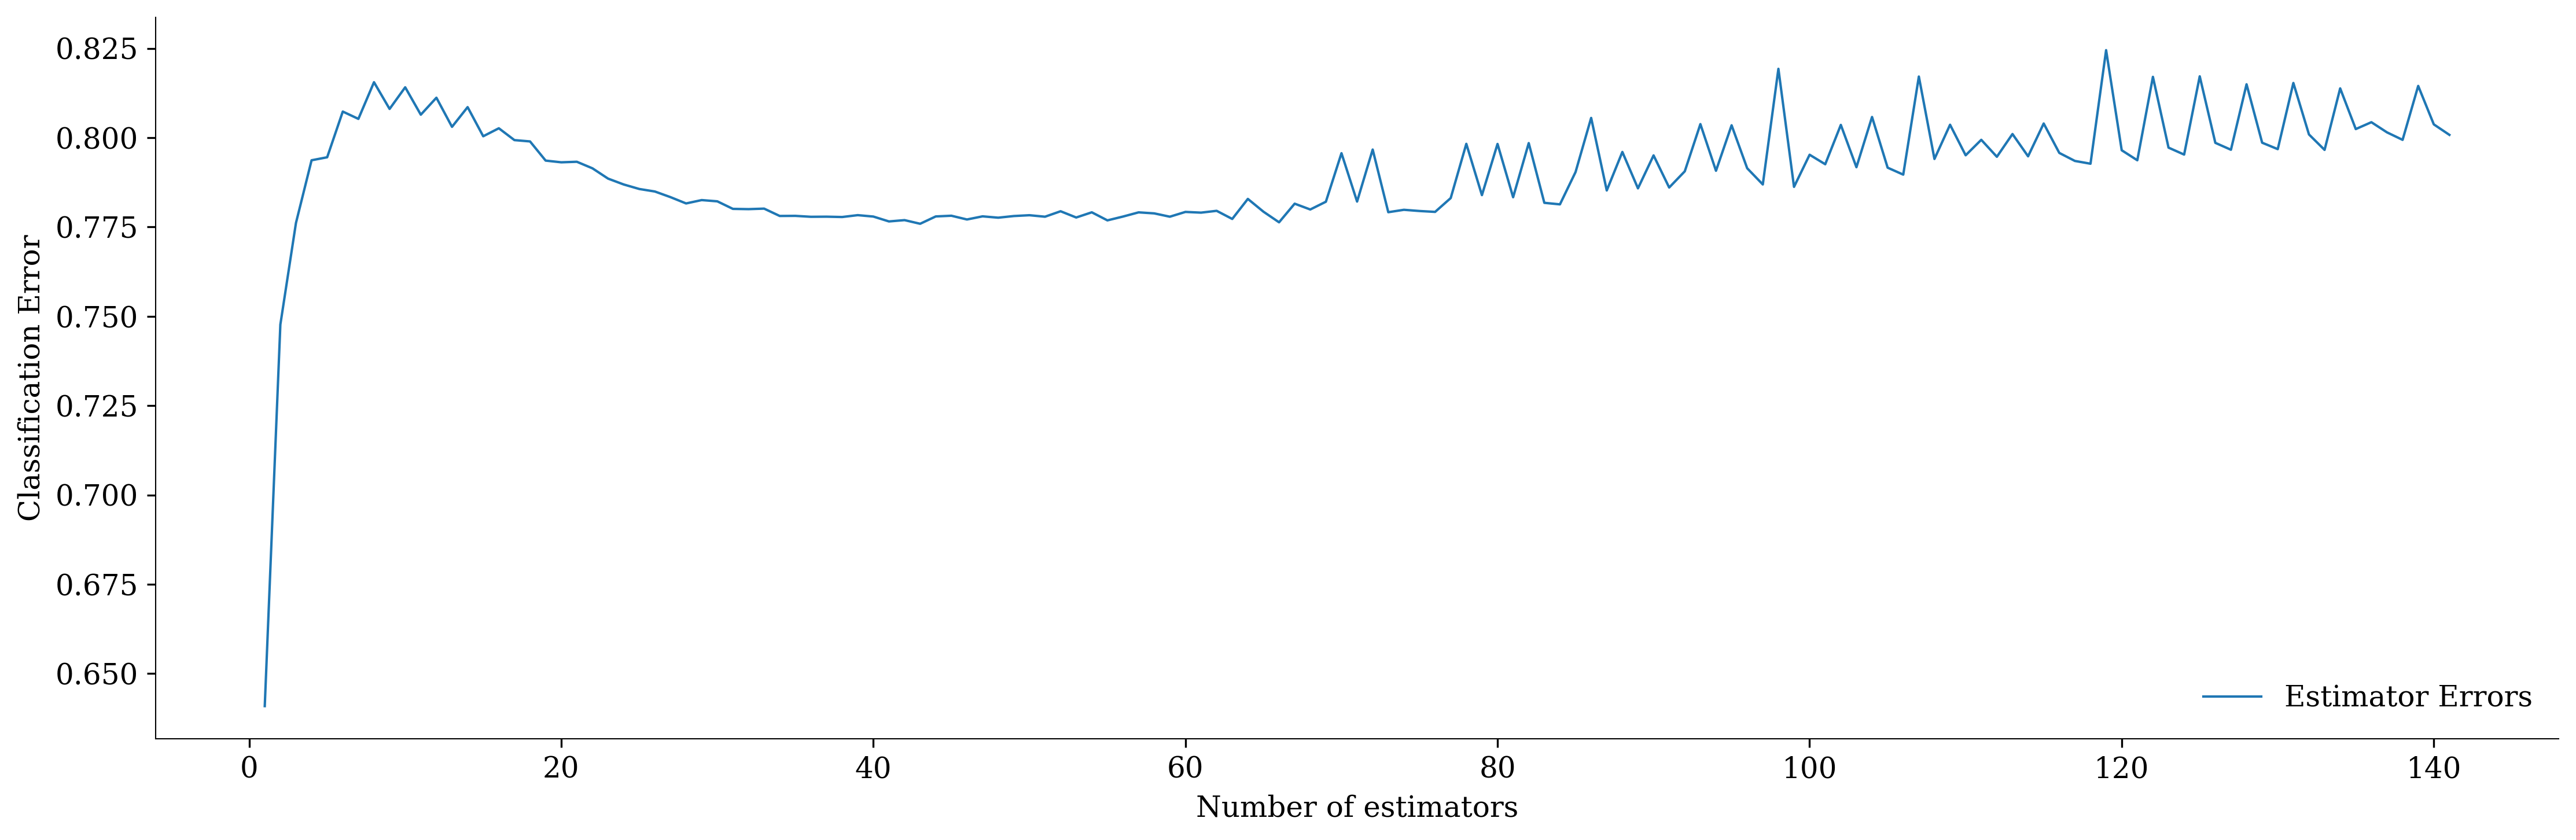

In [127]:
errors = ada_best_model.estimator_errors_

plt.figure(figsize=(15, 5))
sns.lineplot(x=list(range(1, len(errors)+1)), y=errors, label='Estimator Errors')
plt.xlabel('Number of estimators')
plt.ylabel('Classification Error')
plt.show()

We see from the estimation errors that the model was unable to significantly reduce the estimation error of the estimator. We can therefore see why the ensemble method was unable to improve the accuracy of the model. 

While AdaBoost was unable to increase the accuracy of the model, we are still able to use other ensemble methods, namely Gradient Boosting.

---
#### Saving the model

In [113]:
# import pickle

# pickle.dump(fittedgrid, open('models/adaboost_logreg_model.pkl', 'wb'))

#### Loading the model

In [114]:
fittedgrid = pickle.load(open('models/adaboost_logreg_model.pkl', 'rb'))

---
<a id='gboost'></a>
## Gradient Boosting

Gradient Boost is a machine learning technique for regression and classification problems. It builds the model in a stage-wise fashion like AdaBoost does and it generalizes them by allowing optimization of an arbitrary differentiable loss function. This is the primary difference that Gradient Boosting has with AdaBoost. Gradient boosting can be used to optimize an arbitrary differentiable loss function. This makes it more flexible than other methods, which are usually limited to a specific loss function (such as exponential loss for AdaBoost).

We will therefore be using Gradient Boosting in order to use these different loss functions, hoping to improve on the models created with AdaBoost.

We will begin by creating a base model in which none of the hyperparamters are tuned.

In [155]:
X, y = model_utils.GenerateXy(df)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

In [129]:
from sklearn.ensemble import GradientBoostingClassifier

GB_model = GradientBoostingClassifier()
GB_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [131]:
print(f'The base Gradient Boosting model achieved {GB_model.score(X_test, y_test):.4f} accuracy.')

The base Gradient Boosting model achieved 0.4421 accuracy.


As we can see, the model is able to score relatively well, without tuning the hyperparamters. The default loss function used in this model is the 'log loss' function. Alternatively, we can use the 'deviance' loss function and see how this performs.

In [156]:
GB_model = GradientBoostingClassifier(loss='deviance')
GB_model.fit(X_train, y_train)

score = GB_model.score(X_test, y_test)
print(f'The deviance model achieved {score:.4f} accuracy.')

The deviance model achieved 0.4432 accuracy.


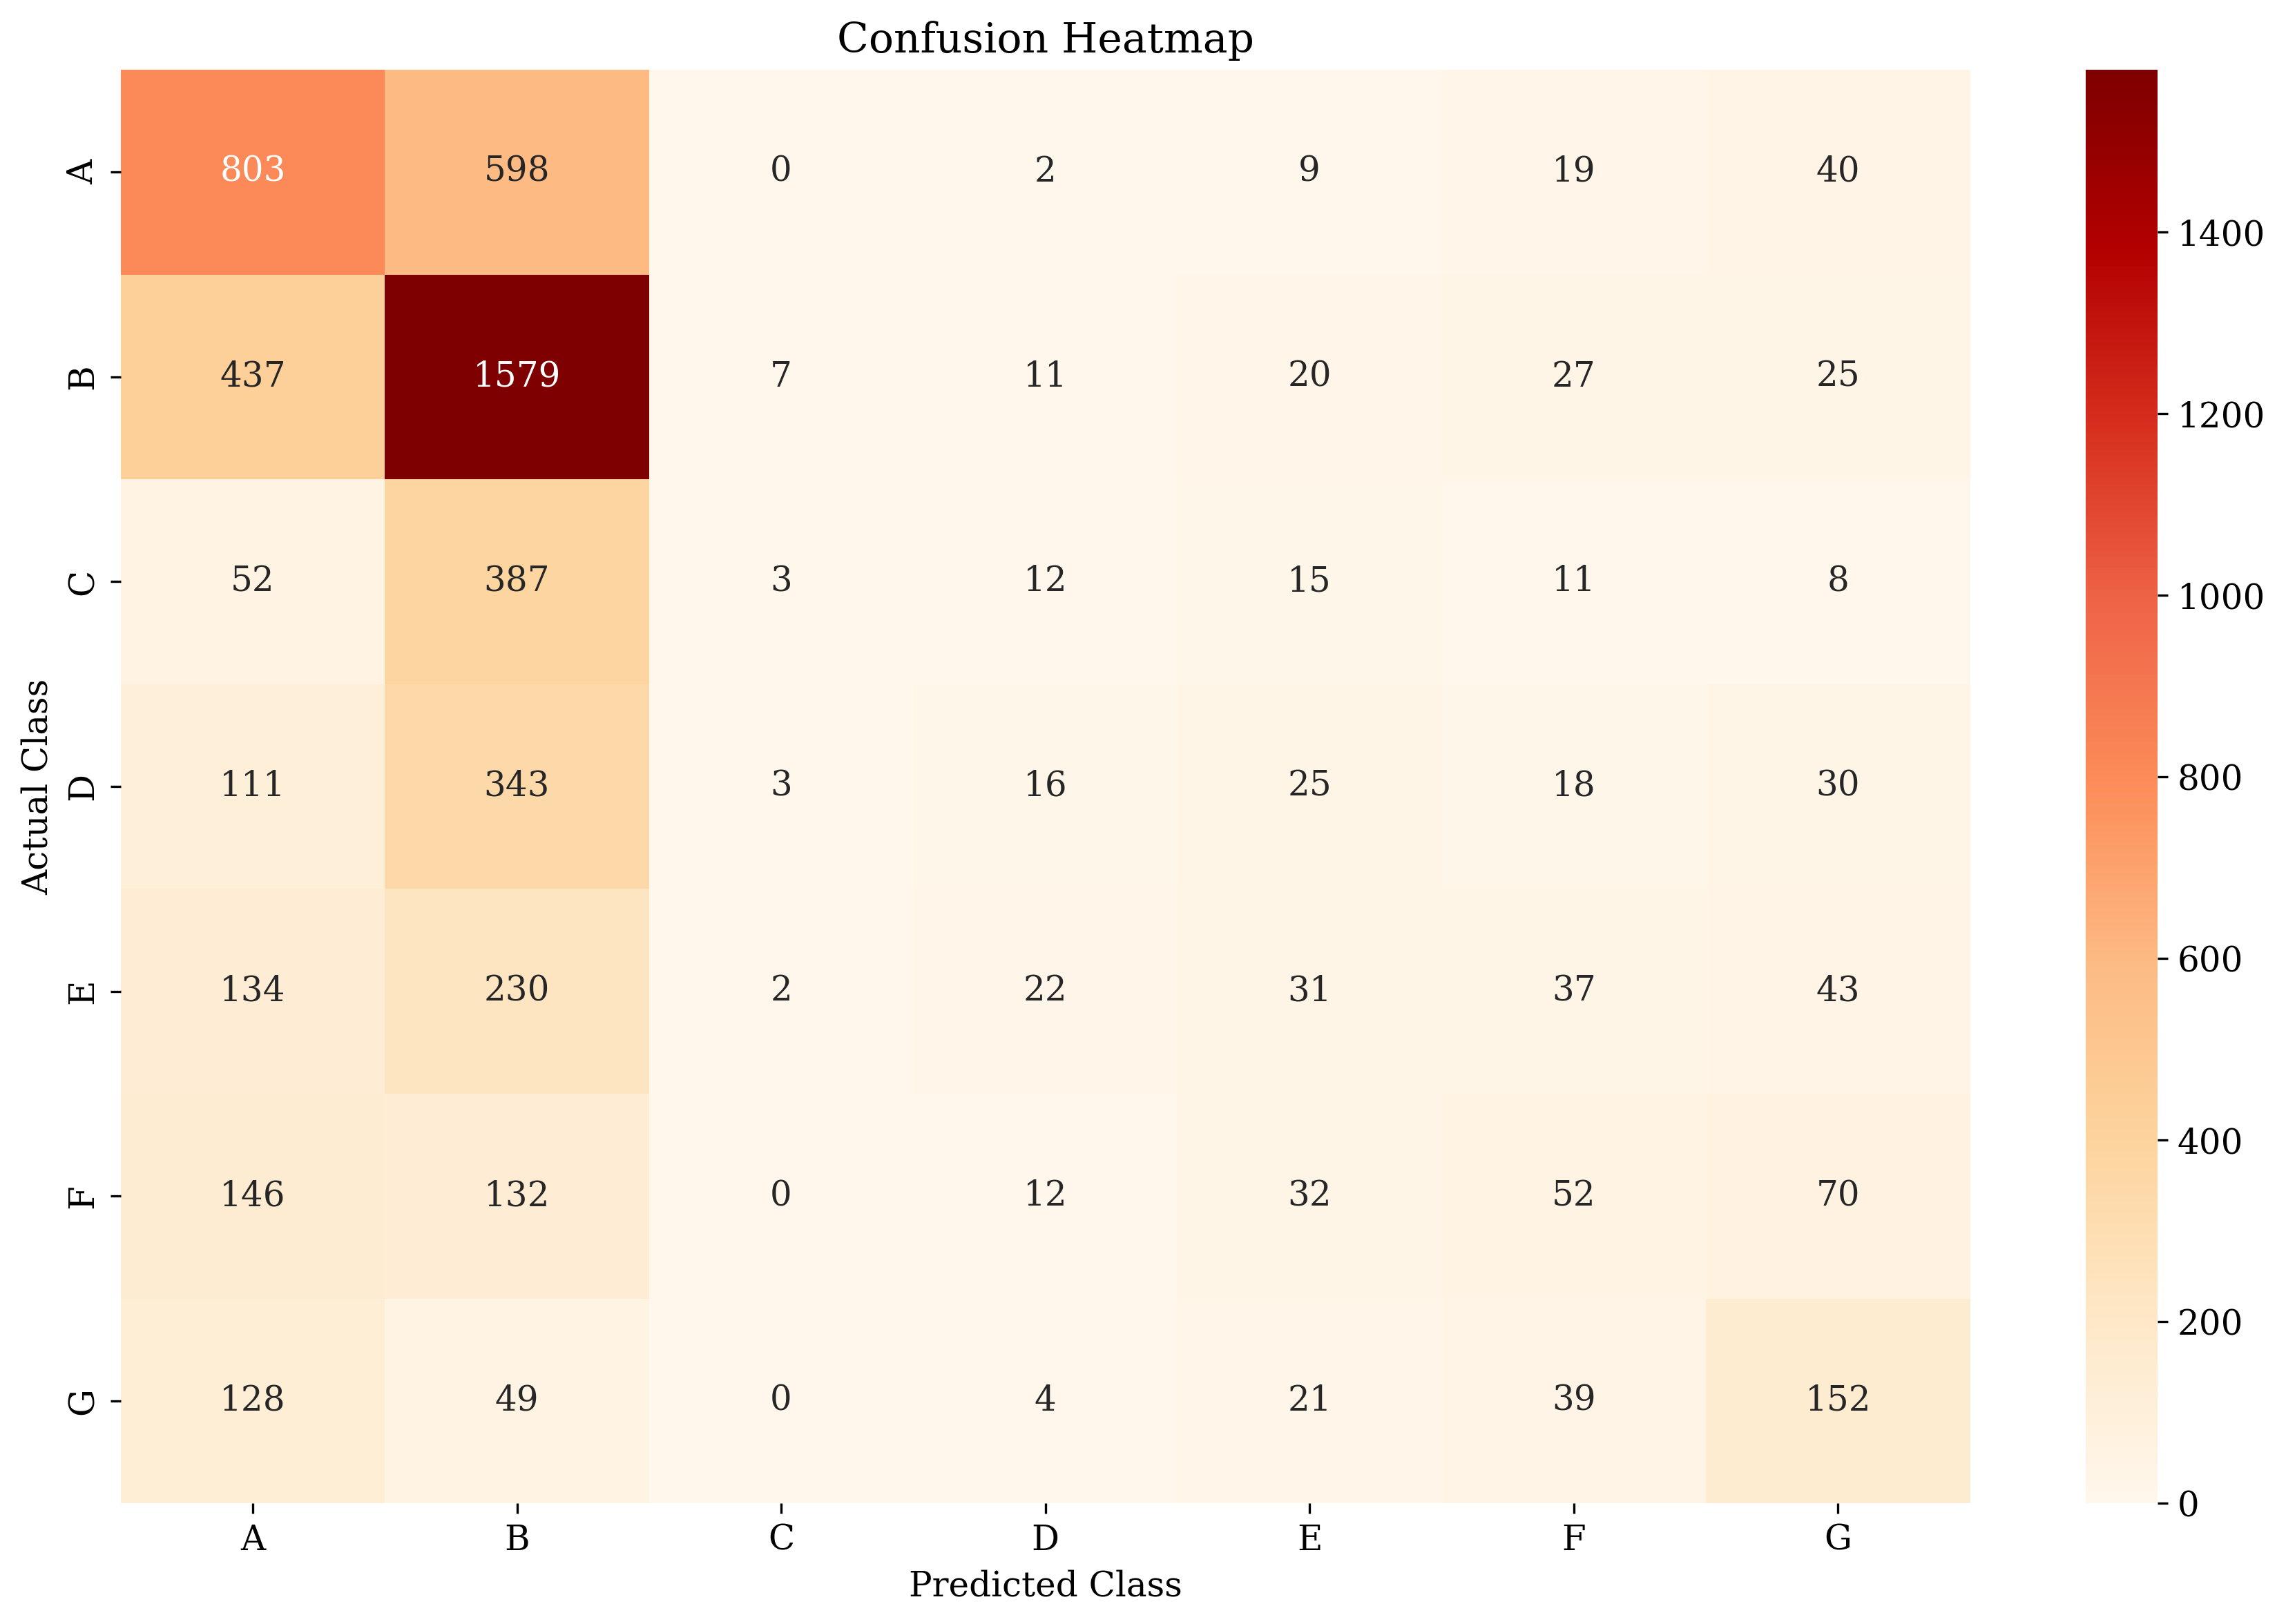

              precision    recall  f1-score   support

           A       0.44      0.55      0.49      1471
           B       0.48      0.75      0.58      2106
           C       0.20      0.01      0.01       488
           D       0.20      0.03      0.05       546
           E       0.20      0.06      0.10       499
           F       0.26      0.12      0.16       444
           G       0.41      0.39      0.40       393

    accuracy                           0.44      5947
   macro avg       0.31      0.27      0.26      5947
weighted avg       0.38      0.44      0.38      5947



In [157]:
model_utils.PlotConfusionMatrix(GB_model, X_test, y_test)

From the classification report, we see that some of the f1 scores are higher than previous values, while the overall accuracy has increased too. We can validate that this model performs better than any other models we created by usign a cross-validation.

In [67]:
from sklearn.model_selection import cross_val_score

score = np.mean(cross_val_score(GB_model, X_train, y_train, cv=5, verbose=1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 2.5min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s


[CV] END .................................................... total time= 2.5min
[CV] END .................................................... total time= 2.5min
[CV] END .................................................... total time= 2.5min
[CV] END .................................................... total time= 2.5min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.5min finished


In [68]:
print(f'The cross-validated score of the Gradient Boosting model is: {score}')

The cross-validated score of the Gradient Boosting model is: 0.4569296741343457


Although only a minor improvement we do see that the score of the model has increased using Gradient Boosting. It would therefore be useful to run a grid search to see which hyperparameters optimise the performance of the model. In the grid search we will, as with the AdaBoost, use different learning rates, and different number of estimators (this will be less extensive than in previous models as this is a computationally expensive and time consuming process)

In [135]:
cachedir = mkdtemp()

estimators = [('model', GradientBoostingClassifier())]

pipe = Pipeline(estimators, memory=cachedir)

params = [
    {
        'model__n_estimators': [10, 50, 100],
        'model__learning_rate': learning_rate_range,
        'model__loss': ['log_loss', 'deviance']
    }
]

grid = GridSearchCV(pipe, param_grid=params, cv=5, verbose=2)
fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=50; total time=   0.0s
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=50; total time=   0.0s
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=50; total time=   0.0s
[CV] END model__learning_rate=0.1, model__loss=log_loss, model__n_estimators=50; total time=   0.0s
[CV] END model__learning_rate=0.1, mod

[CV] END model__learning_rate=1, model__loss=deviance, model__n_estimators=50; total time=  39.0s
[CV] END model__learning_rate=1, model__loss=deviance, model__n_estimators=50; total time=  39.1s
[CV] END model__learning_rate=1, model__loss=deviance, model__n_estimators=50; total time=  39.2s
[CV] END model__learning_rate=1, model__loss=deviance, model__n_estimators=100; total time= 1.3min
[CV] END model__learning_rate=1, model__loss=deviance, model__n_estimators=100; total time= 1.3min
[CV] END model__learning_rate=1, model__loss=deviance, model__n_estimators=100; total time= 1.3min
[CV] END model__learning_rate=1, model__loss=deviance, model__n_estimators=100; total time= 1.3min
[CV] END model__learning_rate=1, model__loss=deviance, model__n_estimators=100; total time= 1.3min
[CV] END model__learning_rate=1.5, model__loss=log_loss, model__n_estimators=10; total time=   0.0s
[CV] END model__learning_rate=1.5, model__loss=log_loss, model__n_estimators=10; total time=   0.0s
[CV] END mo

In [136]:
fittedgrid.score(X_test, y_test)

0.443248696821927

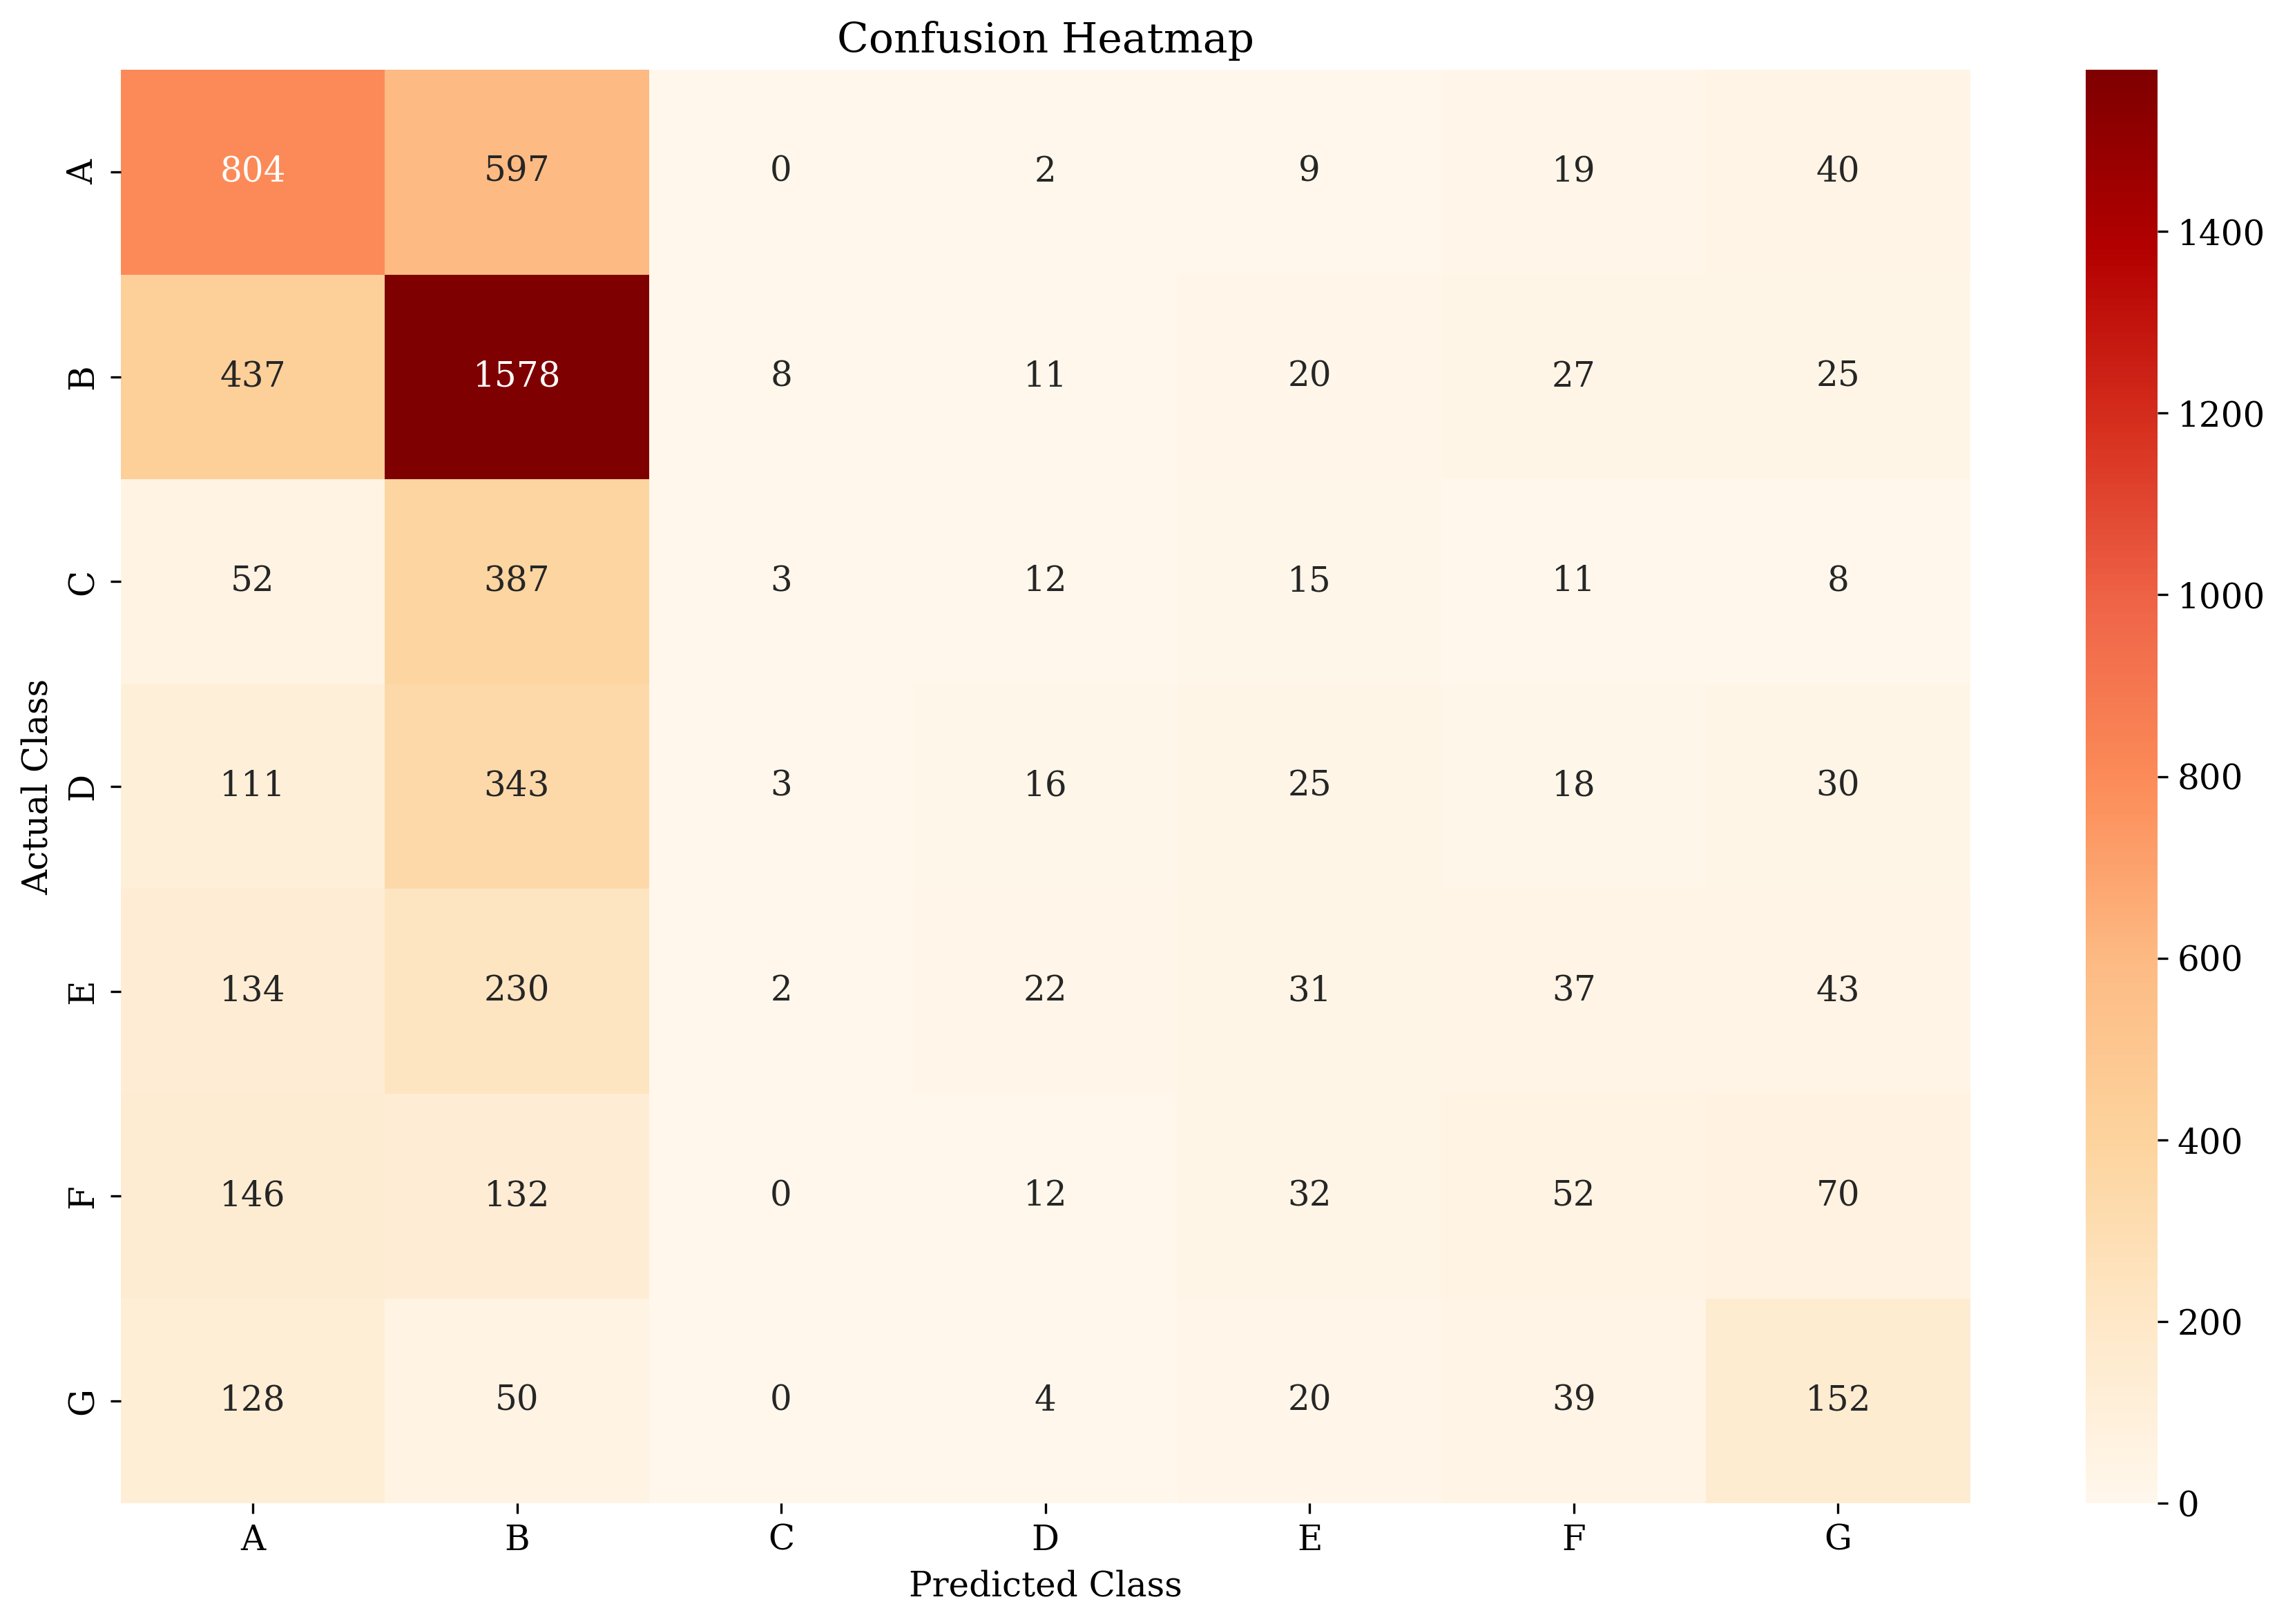

              precision    recall  f1-score   support

           A       0.44      0.55      0.49      1471
           B       0.48      0.75      0.58      2106
           C       0.19      0.01      0.01       488
           D       0.20      0.03      0.05       546
           E       0.20      0.06      0.10       499
           F       0.26      0.12      0.16       444
           G       0.41      0.39      0.40       393

    accuracy                           0.44      5947
   macro avg       0.31      0.27      0.26      5947
weighted avg       0.38      0.44      0.38      5947



In [153]:
model_utils.PlotConfusionMatrix(fittedgrid, X_test, y_test)

As with all the models created so far, this model is still unable to classify fires that fall within the intermediary fire classes. We can therefore move on to our final, and hopefully most powerful, boosting method: XGBoost.

---

#### Saving the model

In [152]:
# pickle.dump(fittedgrid, open('models/gradient_boost_model.pkl', 'wb'))

#### Loading the model

In [ ]:
fittedgrid = pickle.load(open('models/gradient_boost_model.pkl', 'rb'))

---
<a id='xgboost'></a>
## XGBoost

The final boosting method that we will be using is XGBoost. Officially called Extreme Gradient Boosting, XGBoost is one of the most popular boosting methods and has gained popularity after it was consistently used to win data competitions hosted by online organisations such as Kaggle. As can be deciphered from the name, XGBoost is an implementation of gradient boosted decision trees designed to maximise speed and performance.

Apart from speed and performance, XGBoost boasts other qualities, such as being particularly effective when there is a large amount of training data available. XGBoost models are also relatively resistant to overfitting, which can be a problem with other machine learning methods. On top of this they can often provide very accurate predictions. Despite its qualities, XGBoost is not without flaws. XGBoost models are not the simplest machine learning models to understand or interpret. 

Given this number of benefits, we will be using XGBoost in the hopes of generating a better model than previous, although realistically the performance will still be limited. 

To begin we will create a simple XGBoost classifier.

In [145]:
from xgboost import XGBClassifier

xgboost = XGBClassifier(objective='multi:softmax', num_class=7, eval_metric='mlogloss')
xgboost.fit(X_train, y_train)

print(f'XGBoost score: {xgboost.score(X_test, y_test)}')

XGBoost score: 0.462922481923659


Immediately we are able to achieve a score higher than any we have seen so far. Let us see the confusion matrix and classification report of this particular model.

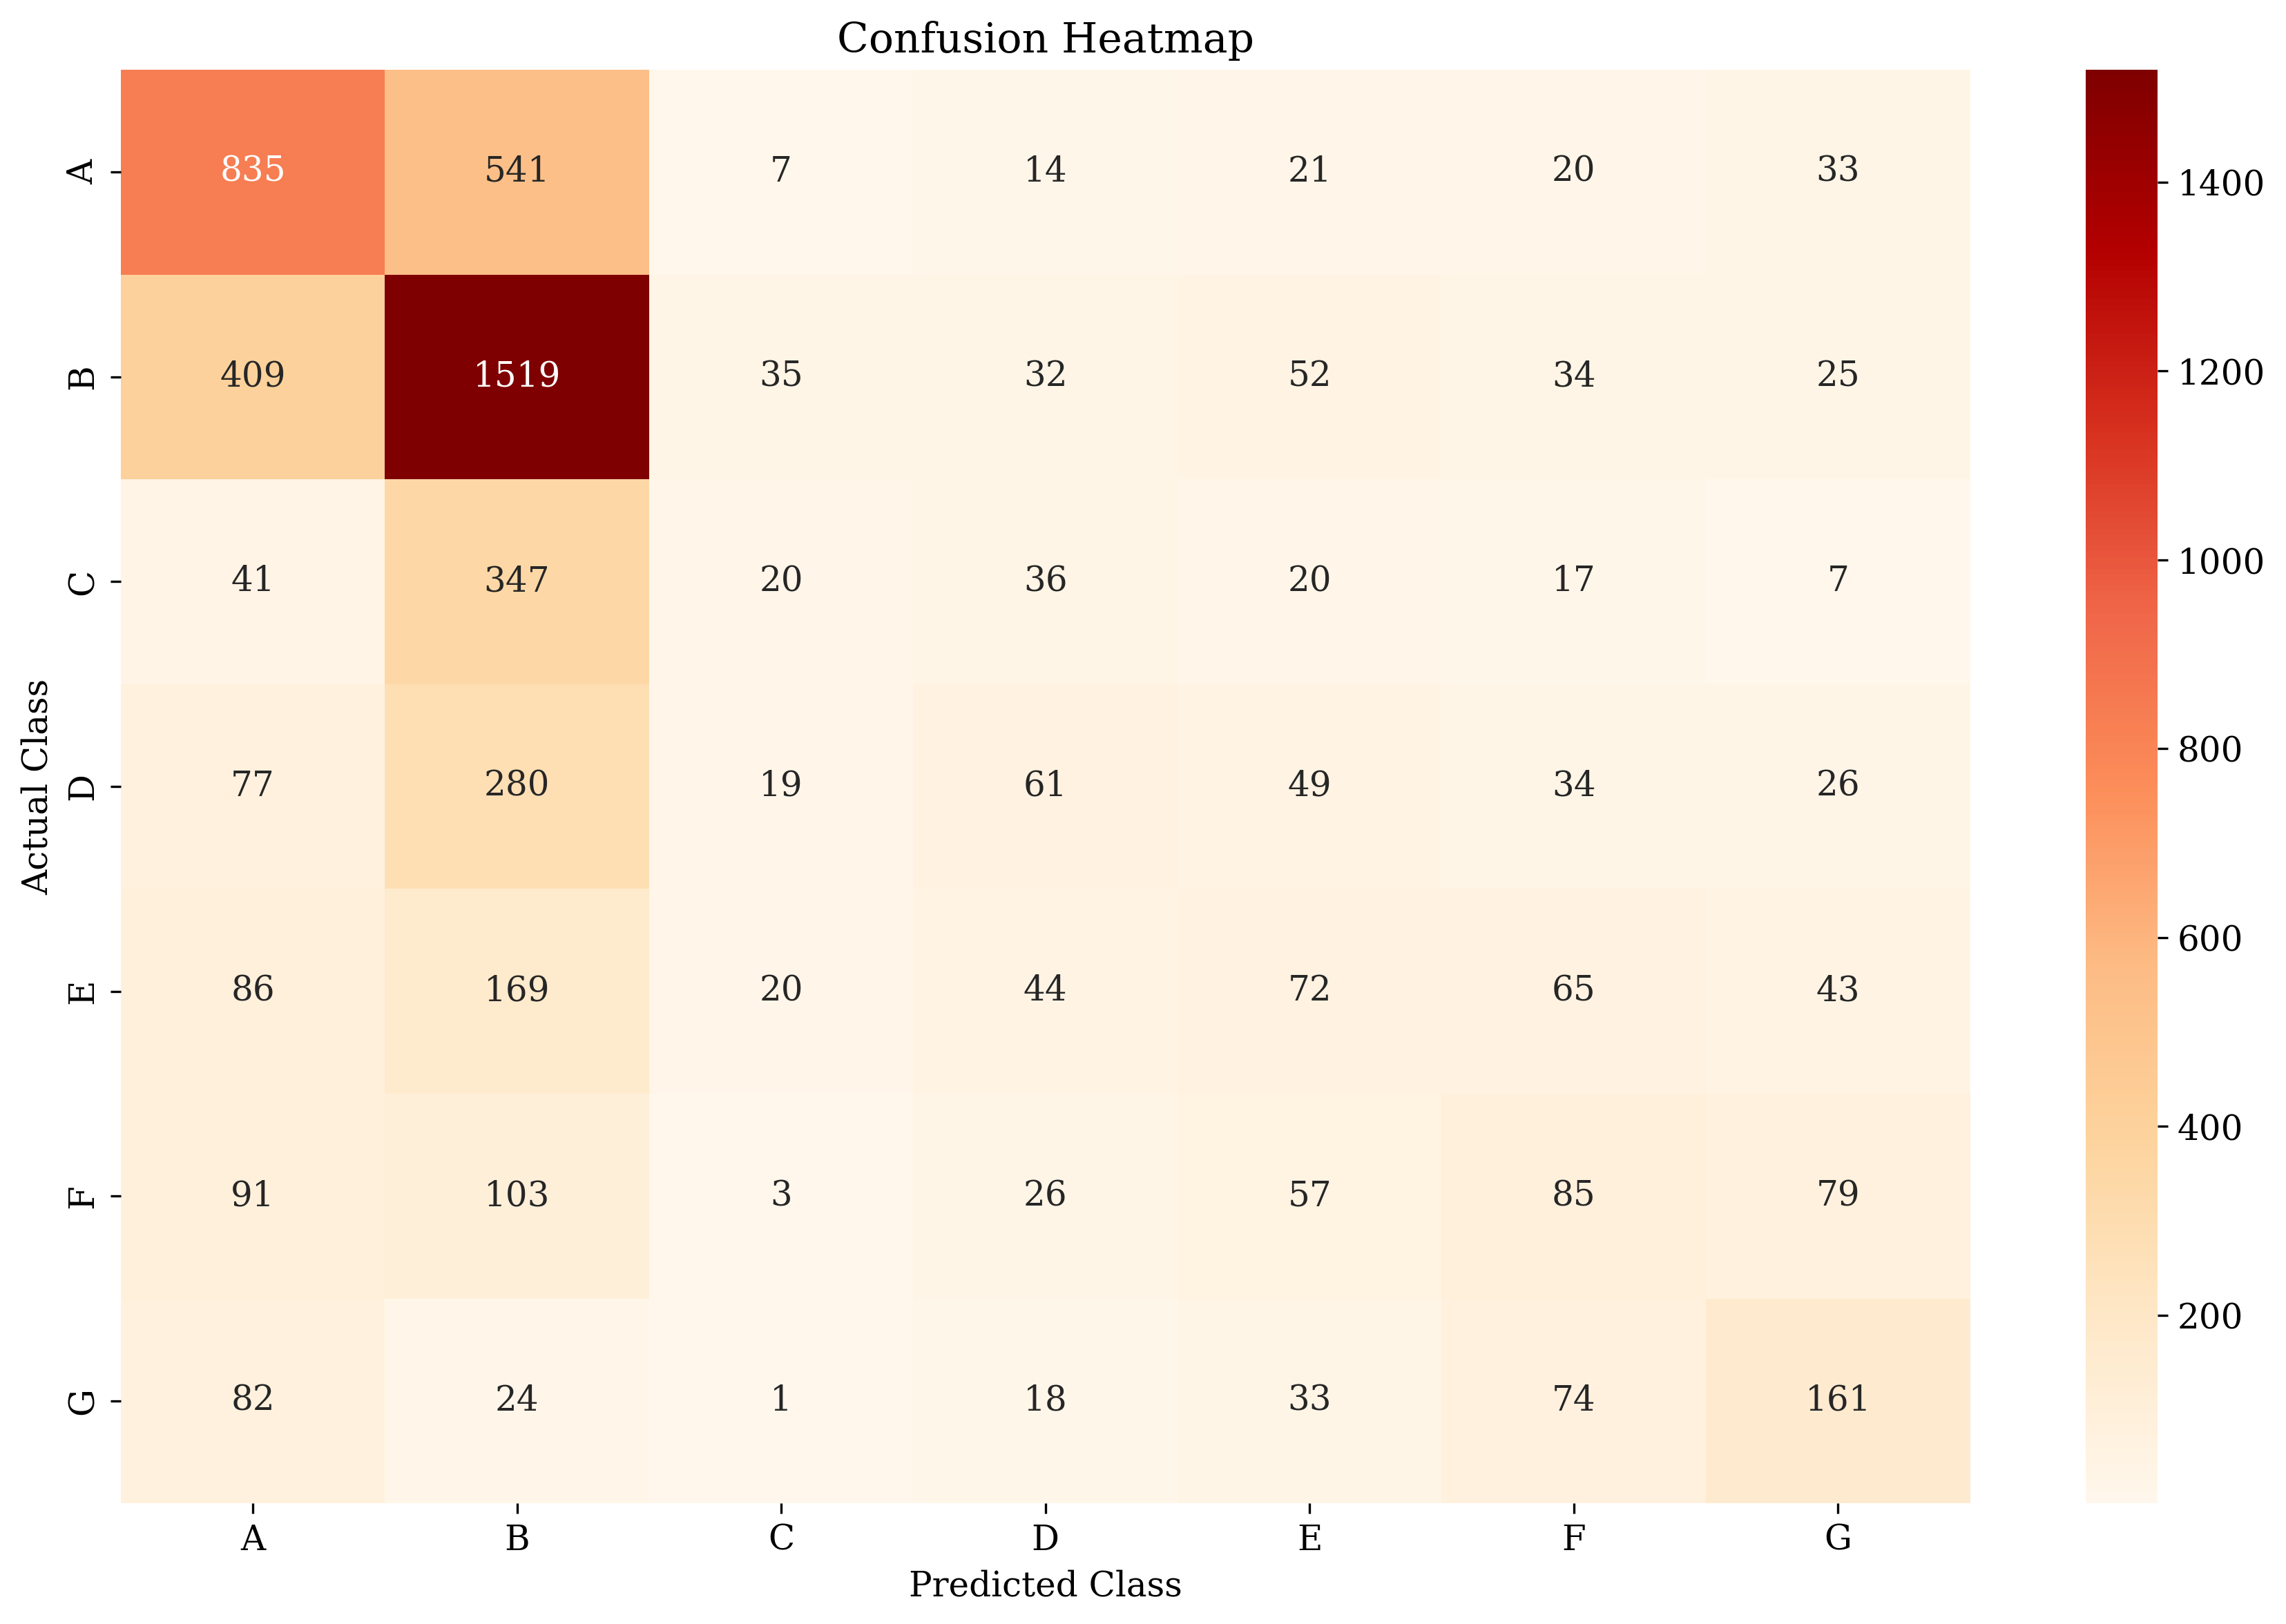

              precision    recall  f1-score   support

           A       0.52      0.57      0.54      1471
           B       0.51      0.72      0.60      2106
           C       0.19      0.04      0.07       488
           D       0.26      0.11      0.16       546
           E       0.24      0.14      0.18       499
           F       0.26      0.19      0.22       444
           G       0.43      0.41      0.42       393

    accuracy                           0.46      5947
   macro avg       0.34      0.31      0.31      5947
weighted avg       0.42      0.46      0.42      5947



In [150]:
model_utils.PlotConfusionMatrix(xgboost, X_test, y_test)

The accuracy of the model was not the only metric that increased. Most of the precision and recall values were increased and only class D precision fell from 0.29 to 0.26.

While we could run another grid search in an attempt to find the optimum model, given the quality of the features we will most likely not be able to increase the accuracy of a model significantly. As we have done at previous stages, we can perhaps redirect our attention to a differnt task. Whilst we are still going to try and build a classification model, we will focus more specifically on the smaller fires (those that fall within the categories A-D). In doing so we are reducing the imbalances in our data set, meaning that we are able to create a model that will be better at classifying smaller fires.



---
<a id='smote'></a>
## Using SMOTE

In previous notebooks, one of the ways that we attempted to improve the accuracy of our models was by using SMOTE and other resampling methods. Ultimately, however, we found that these methods were unable to improve the accuracy of our model. This is due to the fact that the features are bad indicators of fire size, to the point that synthesising new observations may actually just be damaging to the model, rather than useful. It therefore seemed like an unnecessary step in our process to upsample using SMOTE. We will however build some rudimentary models on some data that has been upsampled using SMOTE and see how the baseline models perform when this step has been applied.

In [159]:
from imblearn.over_sampling import SMOTE

X, y = model_utils.GenerateXy(df)

# instantiate SMOTE sampler, fit it to the training data, then resample the data
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(X_train, y_train)

In [160]:
from sklearn.tree import DecisionTreeClassifier

# Fit model to all and see which performs best
adaboost_sm = AdaBoostClassifier(DecisionTreeClassifier(min_samples_leaf=10, max_depth=6))
gradient_boost_sm = GradientBoostingClassifier(min_samples_leaf=10, max_depth=6)
xgboost_sm = XGBClassifier(objective='multi:softmax', num_class=7, eval_metric='mlogloss')

adaboost_sm.fit(X_train_sm, y_train_sm)
gradient_boost_sm.fit(X_train_sm, y_train_sm)
xgboost_sm.fit(X_train_sm, y_train_sm)

print('AdaBoost Test Score: ', adaboost_sm.score(X_test, y_test))
print('Gradient Boost Test Score: ', gradient_boost_sm.score(X_test, y_test))
print('XGBoost Test Score: ', xgboost_sm.score(X_test, y_test))

AdaBoost Test Score:  0.2935934084412309
Gradient Boost Test Score:  0.4212207835883639
XGBoost Test Score:  0.4336640322851858


While this demonstration is rudimentary, it elucidates our point that using SMOTE in this scenario would have been an unnecessary addition to our workflow.

---
<a id='conc'></a>
## Evaluation of Ensemble Methods

Ensemble methods have proven themselves to be a very powerful tool when looking at classification problems. Although ensemble methods were unable to significantly improve the accuracy of our model, this was to be expected considering that the performance of decision and logistic regression models prior to this were already performing suboptimally. For us to fully be able to exploit ensemble methods, we either need to improve the decision tree and logistic regression models - which we have attempted - or we can reframe our classification problem, and simplify it to the point that our model is able to score higher, while still maintaining some utility - that is to say, our question should not be reframed to the point that it is trivialised. The next notebook will therefore tackle this, and will hopefully use ensemble method in a more productive way than we have in this notebook.